# 手撕代码到胃食用系列①：基于PyTorch手撕各种Optimizer优化器，进一步向“祖坟”刨根问底

这部分代码，我们将要逐个实现以下几种常见且具有代表性的优化器算法：
- SGD：随机梯度下降；
- SGD with momentum：带标准动量优化的SGD；
- AdaGrad：自适应梯度下降优化器；
- AdaDelta：自适应学习率优化器；
- RMSProp：均方根梯度传播优化器（先复刻标准PyTorch库中默认实现的RMSProp）
- RMSPropForTensorflow：均方根梯度传播优化器（改为复刻Tensorflow库中默认的RMSProp）；
- Adam：自适应矩估计优化器；

当然了，全程我们采用的开发框架仍然还是PyTorch，并且我们将完全模拟PyTorch官方对优化器对象的统一代码封装范式；

## 1.SGD：随机梯度下降优化器

In [1]:
# 先完成准备工作 - 导包
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as datas
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 导入python自带的日志输出进度条工具
import tqdm

首先，我们先封装全局超参数对象；

In [2]:
class HyperParameters(object):
    '''
    全局超参数封装
    '''
    
    batch_size = 128
    random_crop = 28
    input_dim = 28 * 28
    hidden_dim = 256
    output_dim = 10
    seed = 1234
    epoch = 5
    
    # 获取当前算力设备的类型
    # 如果cuda生效，即算力环境中有配置好的 gpu 训练卡，则调度 gpu 卡完成训练，否则直接调度 cpu 即可；
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HP = HyperParameters()

In [3]:
# 继续，先固定整个代码空间下的全局唯一的随机种子 - 目的是方便大家后续拿到我的代码之后方便你们复现我代码中的结果，只要你们保持你们代码的随机种子
# 与我的代码中的随机种子一致，那么你看到的代码执行结果与我的代码的执行结果就是相同的
torch.manual_seed(HP.seed)
random.seed(HP.seed)
np.random.seed(HP.seed)

穿插一个小知识点：什么叫图像数据的数据增广？
- 其实，这是后续在讲解CV视觉技术中讲解CNN卷积网络的时候才会涉及的知识点；
- 但其实，图像数据增广很简单，顾名思义：对一个图像数据施加镜像、旋转、投影、高斯噪声等等操作，对原始图像做相关的增广操作，让图像足够拟真现实场景；
- 因为，可能在现实场景中，模型在识别图像的时候可能面对识别一个旋转了一定角度的、镜像的、有一定图像噪点的图像；
- 通过数据增广增加图像数据的拟真，让模型学习的时候得到充分的噪声输入，模型最终将变得强鲁棒；

In [4]:
# 接下来开始准备datasets
# 这里为了更好的对比SGD(with动量)与自适应系列优化器(AdaGrad、Adam等)的效果对比，建议直接采用一个图像分类场景的任务来实现优化器的代码编写
# 所以我们选用图像分类任务中最经典也是最简单的MNIST数据集

# 先实现图像数据增广

# 这里是为了适配MNIST数据集而提前计算好的均值和方差。这里怎么计算的咱们目前暂时不关注，但是没有这两个值，加载进来的 MNIST 手写数字图像就不能完成归一化，所以
# 在此预先初始化这两个参数
mean = 0.13066048920154572
std = 0.30810779333114624

# 通过torchvision的transforms对象，调用其 Compose 方法创建数据增广对象，该对象稍后在加载数据集的时候就直接传入，载入的每一张图就都会按照这里的封装预先处理好图像
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5), # 对图像做旋转操作
                            transforms.RandomCrop(HP.random_crop, padding = 2), # 对图像做随机裁剪，固定一个统一尺寸大小的图像区域
                            transforms.ToTensor(), # 将加载进来的图像对象处理并转换为 tensor 张量
                            transforms.Normalize(mean = [mean], std = [std])]) 
                            # 对图像做归一化，归一化需要两个参数，一个是图像的均值，一个是图像的标准差
# 1.加载MNIST数据集
train_data = datasets.MNIST(
    root = './data/', # 指定数据集的存放路径
    download=True, # 数据集是否需要下载；True表示需要
    train=True, # 下载的是否是训练集？
    transform=train_transforms, # 是否要在加载数据时同步对图像数据完成数据增广
)

然后，我们开始封装数据集加载对象 dataloader；

In [5]:
# 封装 dataloader 对象
train_iterator = datas.DataLoader(
    train_data, # 指定所需封装的数据集对象
    shuffle=True, # 在按照一个 batch 进行数据集加载对象封装前，对数据样本做 shuffle，即随机重排；
    batch_size=HP.batch_size,
    drop_last=True # 最后不足一个batch 大小的样本要不要？True 就表示不要了
)

至此，我们预先模拟了一个测试数据的处理和封装过程；

接下来为了完整测试各个优化器，我们还需要准备一个假个嘛噶的神经网络；

这里我们同样遵循 PyTorch 的标准封装逻辑，即基于面向对象封装一个可训练全连接深度神经网络；

In [6]:
# 临时测试：当前总样本数量下，按照 batch_size=128 计算，总计得到多少个 batch？
print(f'full samples number is:{len(train_data)}')
print(f'current batch_size is:{HP.batch_size}')
print(f'batch numbers is:{len(train_iterator)}')

full samples number is:60000
current batch_size is:128
batch numbers is:468


In [7]:
# 奥沙利晨，你先明确一个点：后续网络的 forward 中传入的 x 就来自于这里你封装好的 468 个 batch 中的某一个
for batch in train_iterator:
    print(f"one of a batch's size is:{batch[0].size()}")
    break

one of a batch's size is:torch.Size([128, 1, 28, 28])


从上述输出的当前封装好的一个 batch 数组的形状来看：
- 第一维：表示当前 batch 数组中有多少个样本：128 个；
- 第二-第四维：表示当前 batch 数组中一个对象的维度；对象：图像；维度：三维；
	- 图像第一维：表示通道数；这里为 1，即表示 MNIST 数据集中给到的每一个手写数字图是灰度图；
    - 图像第二维：就表示图像的宽度；
    - 图像第三维：就表示图像的高度；
那么，这里为何图像的第二、第三维是 28 呢？
- 因为你前面已经对图像做过裁剪了；
在这里做的：
```python
# 通过torchvision的transforms对象，调用其 Compose 方法创建数据增广对象，该对象稍后在加载数据集的时候就直接传入，载入的每一张图就都会按照这里的封装预先处理好图像
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5), # 对图像做旋转操作
                            transforms.RandomCrop(28, padding = 2), # 对图像做随机裁剪，固定一个统一尺寸大小的图像区域
                            transforms.ToTensor(), # 将加载进来的图像对象处理并转换为 tensor 张量
                            transforms.Normalize(mean = [mean], std = [std])]) 
                            # 对图像做归一化，归一化需要两个参数，一个是图像的均值，一个是图像的标准差
```

In [8]:
class OptimizerTestMLP(nn.Module):
    '''
    一个假个嘛噶的深度全连接神经网络
    '''
    
    def __init__(self,input_dim,hidden_dim,output_dim):
        '''
        :params:input_dim:输入的维度；
        :params:hidden_dim:中间的隐藏层的维度；
        :params:output_dim:输出的维度；
        '''
        
        # 调用一下当前派生类的基类的初始化方法，self 参数绑定基类的实例对象，方便调用基类的成员(属性/方法)
        super().__init__()
        
        # 初始化网络结构
        self.layer1 = nn.Linear(input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim,hidden_dim)
        self.layer3 = nn.Linear(hidden_dim,output_dim)
        
        # 下一步需要先初始化模型权重参数
        self.init_parameters()
        
    def init_parameters(self):
        '''
        自定义实现模型权重初始化 - 我们直接使用 kaiming 法进行初始化
        '''
        
        # 1.先获取当前网络模型中的所有可训练权重参数 - 网络的权重参数在哪里获取？在当前模型；当前模型在哪里？
        # 此时，当你通过named_parameters方法获取模型所有可训练权重参数之后，你要思考：当前网络中的每一个线性层是否包含 bias 偏置？
        # 注意：一般来说，可训练的模型权重参数和可训练的模型权重偏置(参数中的一种)，这两部分建议采用不同的初始化方法
        for name,layer_params in self.named_parameters(): # 你这里当前网络对象self为何有一个可调用的named_parameters()方法？
            if 'weight' in name:
                # 如果是当前网络层中的权重参数，则采用kaiming法进行初始化，对应的激活函数后续会选择为 relu
                nn.init.kaiming_normal_(layer_params,nonlinearity='relu') # 这里就说明稍后你在构建模型训练脚本的时候你采用的激活函数是 relu 激活
            elif 'bias' in name:
                # 否则如果是 bias 偏置，则使用全 0 进行常数初始化
                nn.init.constant_(layer_params,0) # 
            # print(f'tmp:{index}')
            # break
    
    # 加下来开始实现当前模型的forward前向计算过程
    def forward(self,x):
        '''
        前向计算过程
        '''
        
        # 1.先进来的是x，x则是预先封装好的一个batch对象，里面包含128条样本
        batch_size,*_ = x.shape
        
        # 2.x进来后，为了方便进入ffn(feedforward network,前馈神经网络)计算，当前 x(图像) 必须给我拉直了。
        x = x.view(batch_size,-1) # 这就是拉直了，拉直为一个列向量
        
        # 开始按照网络的层级结构 forward
        return self.layer3(F.relu(self.layer2(F.relu(self.layer1(x)))))
        

这里我们让 AI 来告诉我我们：tensor.view(n,-1)到底是什么意思；
- 在 PyTorch 中，x.view(batch_size, -1) 是一种用于调整张量形状的操作，具体来说，它会改变张量 x 的形状，使其符合指定的形状，其中 batch_size 是你希望的批次大小，-1 是一个特殊的占位符，表示让 PyTorch 自动计算这一维的大小。

所以，这里也就是说：
- x 原本的维度是：`one of a batch's size is:torch.Size([128, 1, 28, 28])`;
- 经过x.view(batch_size, -1)操作之后，x 的维度将变为：[128,1 * 28 * 28]
- 因为这里表示：第一维维数(batch_size)指定好；除此之外剩余所有维度，请 torch 自动帮我计算；
- torch 说了：老哥，既然你不告诉我剩余维度的维数怎么计算，那我就简简单单粗粗爆了：剩余维度我直接乘一起就完事了！

In [9]:
# 简单的临时测试：测试named_parameters方法返回的对象
OptimizerTestMLP(input_dim=64,hidden_dim=512,output_dim=8)

OptimizerTestMLP(
  (layer1): Linear(in_features=64, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=8, bias=True)
)

至此，这个假个嘛噶的神经网络就设计好了，接下来实例化当前类，即得这个假个嘛噶的网络模型；

In [10]:
# 创建模型对象
model = OptimizerTestMLP(HP.input_dim,HP.hidden_dim,HP.output_dim)

In [11]:
# 指定模型训练时所需的损失函数；因为这里我们指定的output_dim为10，即表示模型在做10分类；
# 输入的样本中总计有10种不同手写数字的图像
# 既然是多分类，损失函数就需要选择多分类交叉熵损失函数
criterion = nn.CrossEntropyLoss()

接下来我们加载模型，将其加载到当前算力设备中；我们先通过代码自动获取当前算力设备的类型；

In [12]:
# 模型加载到设备
model = model.to(HP.device)
# 同时，稍后训练的时候，损失函数也要参与梯度下降的计算过程，
# 所以这个计算过程必须跟模型权重所在的计算设备是一致的，否则就会涉及到 cpu下内存中的数据 - gpu 下显存中的数据的通信问题；
criterion = criterion.to(HP.device)

至此，训练前的准备工作完毕；接下来开始封装训练过程；这里我们在训练脚本代码的设计思路上是这样考虑的：
- 因为训练总是在一个规定的 epoch 轮数下，每一轮根据数据集所封装 dataloader 产生的 batch 个数作为一轮下的训练迭代的步数；
- 所以，我们先封装一级函数，表示模型在一个 epoch 下训练所有 step(step=dataloader 的长度，即封装所得的 batch 的个数)；
- 然后，在封装二级函数，其调度一级函数完成一轮训练，二级函数就是实现所有 epoch 下的训练；

In [13]:
# 一级训练脚本函数
def train_epoch(iterator,model,optimizer,criterion,device):
    
    # 4.1 在当前epoch下，准备loss累积的数组
    losses = []
    
    # 4.2 一轮下，获取所有 batch 的数据，迭代的步数就是 dataloader 对象中封装好的 batch 的个数
    # 注意：这里为了后续在训练的过程中，打印日志信息的时候，为了让大家能够方便看清楚训练迭代执行的过程，我们将这个迭代日志输出过程转化为进度条来显示
    for images,labels in tqdm.tqdm(iterator):
        
        # 4.3 一次加载一个 batch 的所有数据
        # 4.3.1 先将数据和标记全部加载至指定算力设备
        images = images.to(device)
        y_true = labels.to(device)
        
        # 4.4 开始反向传播backward之前，先把通过优化器将之前迭代步下所完成计算的梯度 grad 归零
        optimizer.zero_grad()
        
        # 4.5 先进行一次forward,获取模型在当前样本上所得的预测结果
        y_predict = model(images)
        
        # 4.6 再结合样本的真实标记 y_true，构建 loss
        loss = criterion(y_predict,y_true)
        
        # 4.7 loss 开始梯度下降
        loss.backward()
        
        # 4.8 优化器开始更新参数
        optimizer.step()
        
        # 4.9 将本次梯度下降计算所得的 loss 加到 loss 累积数组
        losses.append(loss.item())
        
    return losses 


# 二级训练脚本函数
def train(train_iterator,model,optimizer,criterion,device,n_epoches=HP.epoch):
    
    # 1.初始化loss下降值的存放数组
    losses = []
    
    # 2.开始训练之前，请模型先完成参数初始化
    model.init_parameters()
    
    # 3.训练主循环开始
    for epoch in range(n_epoches):
        
        # 4.这里就是封装好一级训练脚本函数的调用：一级训练函数封装的是一个 epoch 下所有 step 的训练过程；
        epoch_loss = train_epoch(train_iterator,model,optimizer,criterion,device)
        
        # 5.将一个 epoch 下所有 step 迭代完毕后的所有累积 loss 数组继续追加到当前的 loss 累积数组中
        losses.extend(epoch_loss)
    
    return losses
        


此时，我们已经完成了倒数第二个准备工作：训练脚本的封装；
但是，毕竟你已经把每一个迭代 step 下计算所得的 loss 都保存出来了，这意味着你肯定很想可视化模型的 loss 训练下降过程；所以还需把画图函数封装好；

但是，这里又需要思考了：
- 你希望的是本代码 notebook 能够完整论证你开头所提到的多种优化器方法各自的优劣势；
- 那这就意味着你可能需要多图布局，或单个画布内绘制两个或及其以上优化器的 loss 下降可视化；

所以，这个画图函数，还不能只是每次画一张图，而是可以灵活按照你的需求，一次想画几个就画几个；

来吧，让我们完成这两个画图函数的实现；

In [14]:
# 单个画布下绘制单个 loss 下降图的函数
def plot_loss(loss,title=None,ymin=0,ymax=None,figsize=(15,5)):
    '''
    绘制 loss 下降可视化
    '''
    
    # 创建多图布局
    fig,ax = plt.subplots(figsize=figsize)
    
    # 在一个绘图子区域下先绘制 loss 下降图
    ax.plot(loss)
    
    # 设置标题
    ax.set_title(title)
    
    # 设置坐标轴信息
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Step numbers')
    
    # 设置y轴刻度
    ax.set_ylim(ymin=ymin,ymax=ymax)
    
    ax.grid()
              


# 单个画布下绘制多个 loss 下降图的函数
def plot_losses(losses, labels, title=None,ymin=0,ymax=None,figsize=(15,5)):
    '''
    多图绘制
    :params losses:多种不同优化器作用下的同一模型的多个不同 loss 下降过程；
    losses 会直接封装为一个数组，数组中每一个值就表示模型指定某一种优化器进行训练、梯度下降后计算所得的 step 迭代步下的 loss 数值
    :params labels:用来标识哪一个曲线是哪一个优化器的 loss 下降图
    '''
    
    # 创建多图布局
    fig,ax = plt.subplots(figsize=figsize)
    
    # 因为losses会同时传入多个loss下降结果，则遍历，一次拿到每一个loss的下降结果，匹配该结果的 label 同时拿到
    for loss,label in zip(losses,labels):
        ax.plot(loss,label=label)
                
    # 设置标题
    ax.set_title(title)
    
    # 设置坐标轴信息
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Step numbers')
    
    # 设置y轴刻度
    ax.set_ylim(ymin=ymin,ymax=ymax)
    
    ax.grid()
    
    # 因为这里是多图布局，最好加个图例，表示一下哪个颜色的曲线是哪个优化器的下降过程
    ax.legend(loc='upper right')

OK,万事俱备，只欠东风；我们已经做好了优化器测试代码工程的所有前置步骤；接下来：
- 我们正式开始封装不同的优化器；
- 并展示指定该优化器后模型的训练过程；
- 同时记录模型在所有训练 step 迭代步下 loss 下降的具体值；
- 最终使用我们已经封装好的绘图工具，将不同优化器指定下模型的训练 loss 下降过程可视化出来；
- 通过可视化图示的对比，我们亲自感受不同优化器对 loss 下降优化的效果是什么，最终你自然可以理解为何有的优化器性能好，有的优化器性能不好；

那么具体的优化器的代码实现的逻辑是什么呢？
- 我们就直接效仿 PyTorch 封装优化器对象的代码设计思路，即：
- 将梯度归零过程单独封装为 `zero_grad`方法；
- 将优化器迭代更新模型权重的过程单独封装为`step`方法；

这将完全符合PyTorch 中标准封装优化器的代码设计思路；

那就先从最最简单的 SGD：随机梯度下降开始吧；
## 随机梯度下降优化器SGD的手撕 Python 代码实现

In [15]:
# 1.SGD(不带动量)的代码实现
class SGD(object):
    '''
    封装 SGD 优化器
    '''
    
    def __init__(self,model_params,lr=1e-3):
        '''
        :params model_params:优化器待优化的模型权重；
        :params lr:初始化的学习率
        '''
        
        self.model_params = list(model_params)
        self.lr = lr
        
    # 开始封装梯度归零方法
    def zero_grad(self):
        
        # 这里的逻辑非常简单，直接将模型权重一个一个置为None
        for param in self.model_params:
            param.grad = None
            
    # 再封装优化器模型权重更新方法
    # 但是，思考：模型权重的更新所处的上下文环境需要包含梯度更新的环境吗？我就问你一句话：如果梯度还在更新着，你需要此时就通过优化器更新模型权重吗？
    # 当然不是；所以：优化器更新模型权重时代码的上下文环境中，绝对不能存在梯度更新的过程，必须是一个没有梯度更新的过程，即梯度已经更新完毕了，再做模型权重的更新
    # 所以这里需要设定优化器更新模型权重时的上下文环境，且是一个没有梯度更新的上下文环境
    @torch.no_grad() # 即通过 torch 封装好的 no_grad()方法手动将 step 方法的执行上下文环境切换为没有梯度更新的环境
    def step(self):
        '''
        这里其实就是正八经的模型权重更新过程；
        怎么更新？还记得 SGD 的参数更新公式吗？往上直接套，把那个数学公式，直接用代码实现，不就完了吗？
        '''
        for param in self.model_params:
            param.sub_(self.lr * param.grad)
    

补充知识点：

在 PyTorch 的 step 方法封装中，每一个封装好的模型权重 tensor 对象中的每一个模型权重值对象，其都封装了几个常用的数值计算方法：
-  `mul_`；
-  `add_`；
-  `sub_`；
- 当然还有其他的；

那么这三个方法是干什么的：
- 他们都是操作模型权重值对象在原地做数学运算的方法，即：
-  `mul_`就表示在模型权重原有值基础之上做与另一个数值的乘法，代码上来说，即 x *= a；
-  `add_`就表示在模型权重原有值基础之上做与另一个数值的加法，代码上来说，即 x += a；
-  `sub_`就表示在模型权重原有值基础之上做与另一个数值的减法，代码上来说，即 x -= a；

ok，补充的知识点介绍完毕，接下来开始最关键的优化器效果测试；我们先初始化标准 SGD 随机梯度下降优化器；

In [16]:
# 实例化 SGD 优化器 - 这里就需要传入模型的权重参数，优化器优化的就是模型的权重参数
optimizer = SGD(model.parameters())

In [17]:
# 开始让模型使用该优化器，完成一次训练，即可得到模型的训练loss下降的过程结果
sgd_loss = train(
    train_iterator=train_iterator,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=HP.device
)

100%|██████████| 468/468 [00:16<00:00, 27.65it/s]


当训练完毕后，我们开始绘制标准 SGD 随机梯度下降优化器产生的 loss 下降过程，我们看看有什么问题没有；

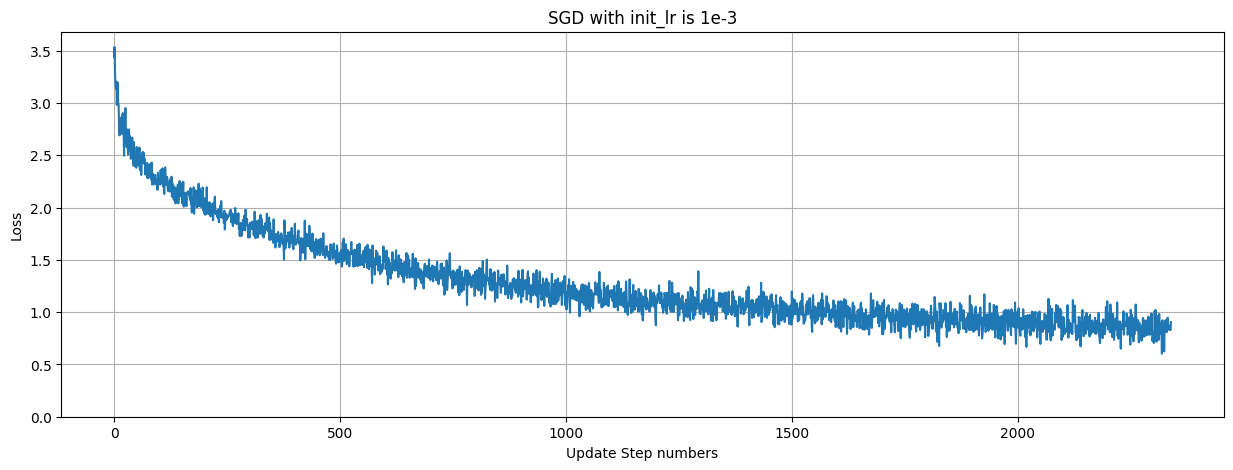

In [18]:
# 可视化当前 loss 下降过程
plot_loss(
    loss=sgd_loss,
    title='SGD with init_lr is 1e-3'
) # 当然，大家要注意：在当前开发环境中，关于绘图对象中可能会出现的图例，标题，坐标轴刻度啊等等文字信息，尽量不要使用中文；为何：可能会乱码，而且有的环境中即使
# 你做了中文乱码的处理，也不一定有用，还是会乱码，所以保持英文命名简单又高效，还是个好习惯；当然：中国 yyds！

OK,第一个绘图结果就出来了，从中你可以发现什么？
- 首先，loss 整体确实是呈现了下降的趋势，这就说明整个优化器基本的优化效果是正确的；
	- 如果你发现，你训练完毕后，对 loss 的下降过程进行可视化，结果发现 loss 不但没下降，反而还在上升，那就废了，你的模型绝对有问题，而且是大问题！
- 但是，同样的，我也发现了：loss 下降的并不平滑、并不润滑、并不丝滑；

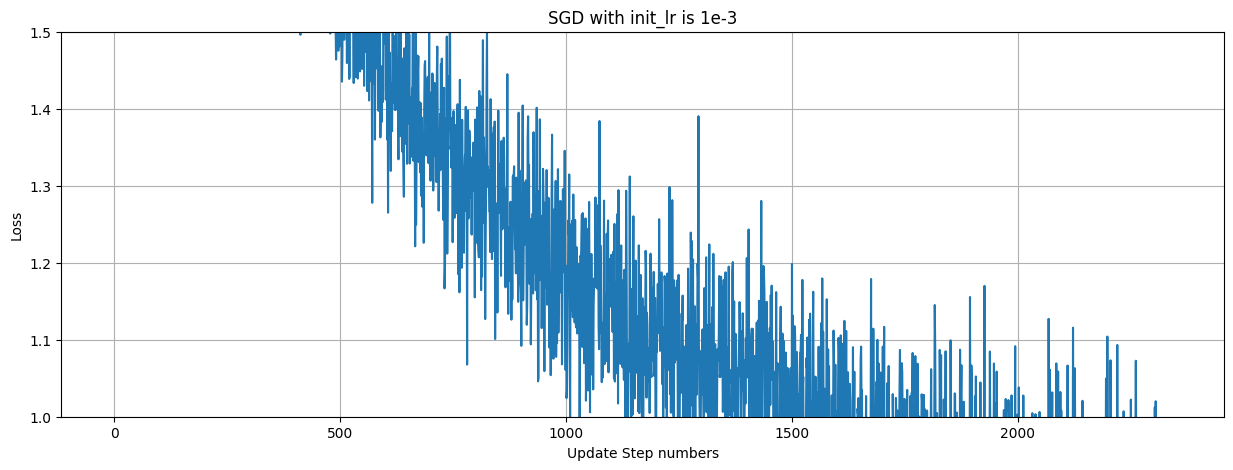

In [19]:
# 我们现在尝试重新画图，但是把y轴纵坐标的区间范围缩小一些；
plot_loss(
    loss=sgd_loss,
    title='SGD with init_lr is 1e-3',
    ymin=1.0,
    ymax=1.5
)

所以，当我们进一步缩小 y 轴可视化的范围时，这个 loss 下降的毛刺现象就展现的更加细致了；

那么现在我们思考：为何 SGD 会产生这种所谓的下降中毛刺现象？
- 原因也很简单，因为你这里的 SGD 就是一个最简简单单，原始的随机梯度下降过程，没有动量的加入，也没有学习率的自适应过程，所以，他的下降不是很顺利，总是产生“跃过极值”的效果；

那么，请问这个现象该怎么改善？你可以考虑对这个 SGD 加入标准动量的约束；

In [20]:
# 带有标准动量的 SGD 随机梯度下降优化器的代码实现
class SGDWithMomentum(object):
    '''
    带有标准动量的 SGD 随机梯度下降优化器实现
    '''
    
    def __init__(self,model_params,lr=1e-3,momentum=0.9):
        '''
        :params model_params:优化器待优化的模型权重；
        :params lr:初始化的学习率；
        :params momentum:动量系数，初始值为 0.9
        '''
        
        # 1.将传入的模型权重参数转化成 list，等待后续的处理
        self.model_params = list(model_params)
        
        # 2.初始化学习率
        self.lr = lr
        
        # 3.设置动量因子，他的目标是累积和衰减历史梯度
        self.momentum = momentum
        
        # 4.为每一个模型权重参数创建一个与其形状相同的零张量，用于存储动量的中间计算结果 - 动量的 cache
        self.v = [torch.zeros_like(p) for p in self.model_params]
        print(f'v is:{self.v}')
        
    # 先实现梯度归零方法
    def zero_grad(self):
        '''
        清除前序迭代步完成后计算所得的梯度，保持梯度归零，等待开启下一次新的参数更新 step
        '''
        for param in self.model_params:
            param.grad = None
        
    # 再实现优化器迭代更新权重参数方法
    @torch.no_grad()
    def step(self):
        '''
        优化器迭代更新模型权重方法
        咱先分析下代码逻辑：
            1.首先，你这是带标准动量的 SGD，你已经提前给你模型中每一个权重初始化了一个全 0 同型张量；
            2.现在你对参数做更新的过程，就是需要先把参数更新公式按照算法原理先实现好；
            3.然后再更新权重参数
        '''
        
        # 1.同时遍历模型权重参数以及每个参数对应的动量 cache v
        for param,v in zip(self.model_params,self.v):
            
            # 2.先更新动量：v = momentum * v + 当前梯度
            v.mul_(self.momentum).add_(param.grad)
            
            # 3.根据更新完毕的动量来更新参数：param = param -lr * v
            param.sub_(self.lr * v)

接下来，我们再测试这个带有标准动量的 SGD 随机梯度下降优化器优化 loss 的效果；

In [21]:
# 实例化当前优化器对象
optimizer = SGDWithMomentum(model.parameters())

v is:[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.,

In [22]:
# 使用当前新的优化器对象重新训练模型，记录新 loss，稍后对新 loss 进行可视化
sgd_with_momentum_loss = train(
    train_iterator=train_iterator,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=HP.device
)

100%|██████████| 468/468 [00:17<00:00, 27.13it/s]


现在开始可视化带有标准动量的 SGD 随机梯度下降优化器的 loss 可视化结果；

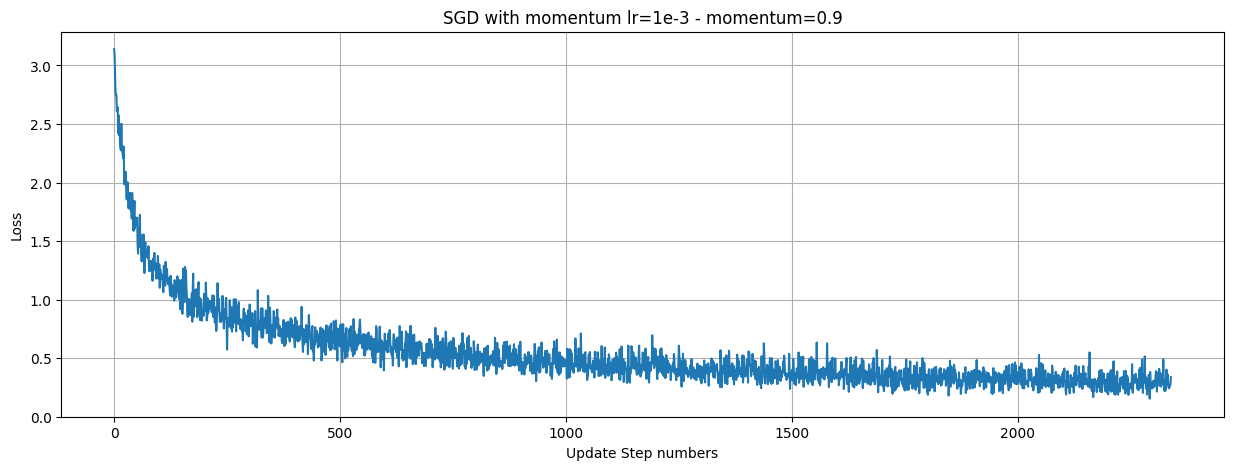

In [23]:
plot_loss(
    loss=sgd_with_momentum_loss,
    title='SGD with momentum lr=1e-3 - momentum=0.9'
)

将其与标准 SGD 下降 loss 可视化对比一下，发现：
- 首先，带有标准动量的 SGD 的下降过程中，毛刺现象有所缓解，但没有根治；
- 其次，带有标准动量的 SGD 收敛到了更低的 loss 极值，即表示：该优化器优化的模型权重进一步靠近了那个更优的局部最优解；

那么，与其这样两个图分开比，不如咱把这两图画到一个画布里，这样对比不是更加直观吗？


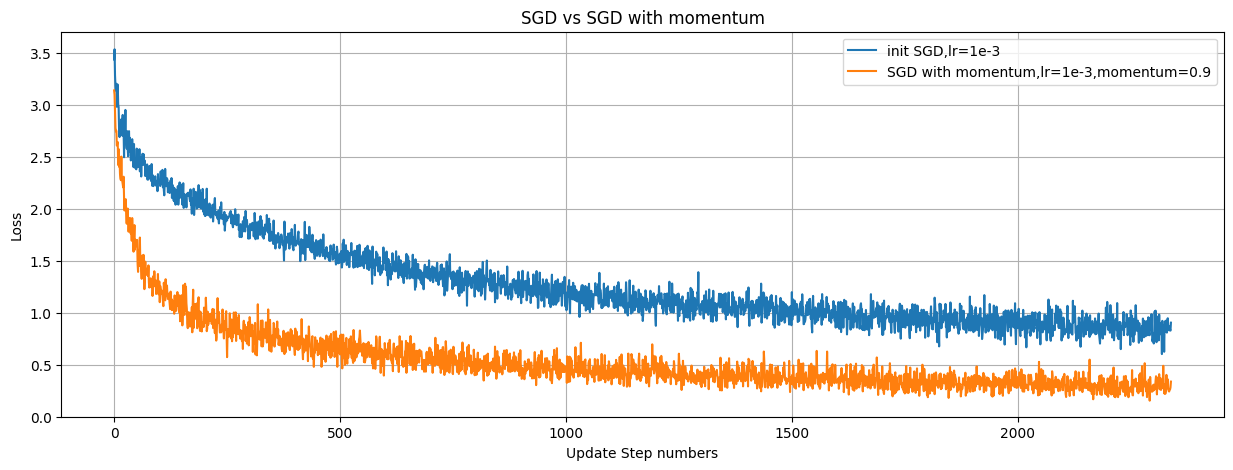

In [24]:
# 将刚才 SGD 与带有标准动量的 SGD 的 loss 可视化图绘制在相同画布下

# 先组织一下 loss
losses = [sgd_loss,sgd_with_momentum_loss]

labels = ['init SGD,lr=1e-3','SGD with momentum,lr=1e-3,momentum=0.9']

# 调用多图绘图函数
plot_losses(losses=losses,labels=labels,title='SGD vs SGD with momentum')

至此，关于标准 SGD 及其带有动量的 SGD 的讨论暂时告一段落，因为说实话，这些方法我们早都已经不用啦，只是在这里当个开胃菜，简单的写一写，画一画，看看效果就行了，这不是重点；重点是自适应系列优化器；

接下来我们先实现那个 AdaGrad 自适应梯度下降优化器；
在开始之前，我们先固定 Adagrad 的计算公式，我们对着公式来实现它：

累积梯度平方的计算公式：
$$
S_{t,i} \;=\;\sum_{\tau=1}^t (g_{\tau,i})^2.
$$

学习率自适应更新的计算公式：
$$
\eta_{t,i}= \frac{\eta}{\sqrt{S_{t,i}} \;+\;\delta},
$$

参数更新的计算公式：
$$
x_{t+1}= x_t \;-\;\eta\,\mathrm{diag}(S_t)^{-\tfrac12}\,g_t.
$$


In [25]:
class Adagrad(object):
    '''
    自适应梯度下降优化器实现
    '''
    
    def __init__(self,model_params,lr=1e-2,init_acc_sqr_grad=0,eps=1e-10):
        '''
        :params model_params:传入的待优化的模型权重；
        :params lr:初始化的学习率；
        :params init_acc_sqr_grad:稍后我们会使用一些 torch 的方法创建一个与参数 p 同型的张量，同时，张量中的值使用init_acc_sqr_grad来填充
        这个张量的目标就是：用于后续的梯度平方的累积
        :params eps:epsilon,就是那个缓解数值稳定的扰动因子，目标是保证分母不为 0
        '''
        
        # 1.将传入的模型权重参数转换为list，方便后续处理
        self.model_params = list(model_params)
        
        # 2.初始化学习率
        self.lr = lr
        
        # 3. 为每个参数初始化累积平方梯度的张量
        # 怎么初始化？使用torch.full_like(p,init_acc_sqr_grad)创建与 p 同型的张量，
        # 并使用init_acc_sqr_grad值来填充这个初始化张量中的数值；当前案例中，我们习惯性的将该值初始化为 0；但一般情况来说，我们可能会选择初始化为一个别的非 0 值
        self.acc_sqr_grads = [
            torch.full_like(p,init_acc_sqr_grad)
            for p in self.model_params
        ]
        
        # 4.初始化这个数值稳定因子
        self.eps = eps
        
    # 梯度归零方法
    def zero_grad(self):
        '''
        梯度归零
        '''
        for param in self.model_params:
            param.grad = None
            
    # 参数迭代更新方法
    @torch.no_grad()
    def step(self):
        '''
        参数的迭代更新过程
        来吧，先分析一下：
            1.反正这里呢，跟刚才那个带标准动量的 SGD 类似，都需要累积梯度，只不过这里累积的是梯度平方，那也就是说在更新参数之前，需要先计算好参数更新公式；
            2.那么第一步就是先累积当前梯度的平方；
            3.然后再计算当前参数学习率的更新；
            4.最终更新权重参数值
        '''
        
        for param,acc_sqr_grad in zip(self.model_params,self.acc_sqr_grads):
            
            # 1.先累积梯度平方
            acc_sqr_grad.add_(param.grad * param.grad)
            
            # 2.计算学习率更新，就是算学习率更新公式中的分母
            std = acc_sqr_grad.sqrt().add(self.eps)
            
            # 3.开始更新权重值
            param.sub_((self.lr / std) * param.grad)    

接下来开始使用 Adagrad 优化器重新训练当前 MLP 模型；

In [26]:
optimizer = Adagrad(model.parameters())

In [27]:
adagrad_loss = train(
    train_iterator=train_iterator,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=HP.device
)

100%|██████████| 468/468 [00:17<00:00, 26.97it/s]


接下来开始绘制 Adagrad loss下降过程；

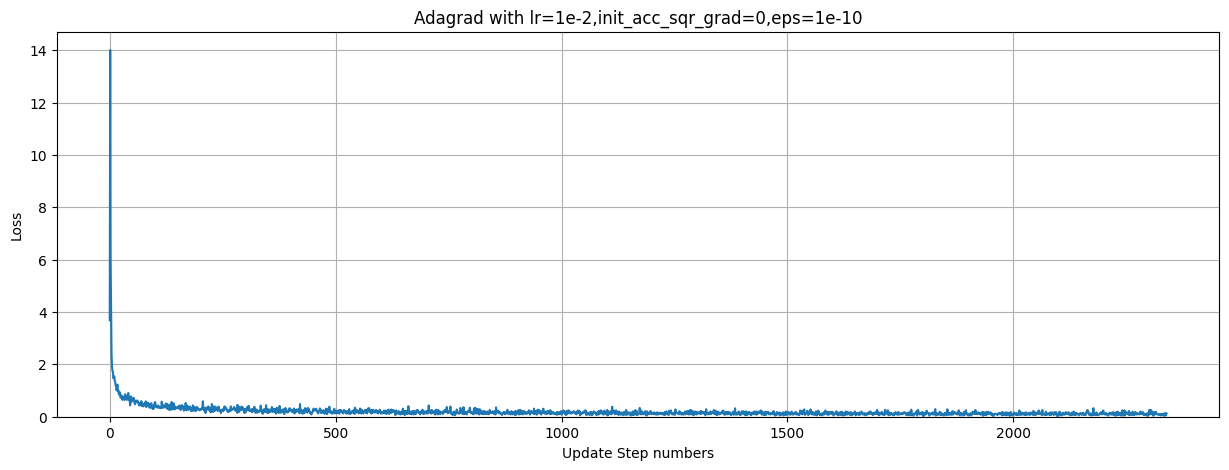

In [28]:
plot_loss(
    loss=adagrad_loss,
    title='Adagrad with lr=1e-2,init_acc_sqr_grad=0,eps=1e-10'
)

阅读上述可视化效果，我们分析一下，Adagrad 有什么问题：
- 首先，优点还是有的，下降的过程相对来说丝滑很多了，即使仍然还有小毛刺，但也只是收敛后在局部微小范围内产生了小毛刺儿；
- 但是，更多的还是这个方法的缺点，即：loss 在很小的迭代步下就快速收敛了，这就说明：越往后的迭代步，参数更新的幅度已经非常非常小了；

请问：为何产生了这种现象？
- 原因其实也很简单：你之前讲原理的时候你就不说了吗？Adagrad 是从最开始就直接累积梯度平方的，它是全局的梯度平方累积，自然伴随训练迭代步增加，累积的梯度外积必然很大，就导致参数的学习率自适应的很小，所以参数更新不动啦，自然 loss 就收敛了，而且收敛的很快；

所以，我们现在通过代码+可视化，结合前序讲解过的算法原理，彻底理解了 Adagrad 的问题所在！

继续；为了进一步看清 Adagrad 的详细下降过程，我们将 y 轴刻度从 5 开始显示，进一步展示详细的下降的局部细节；

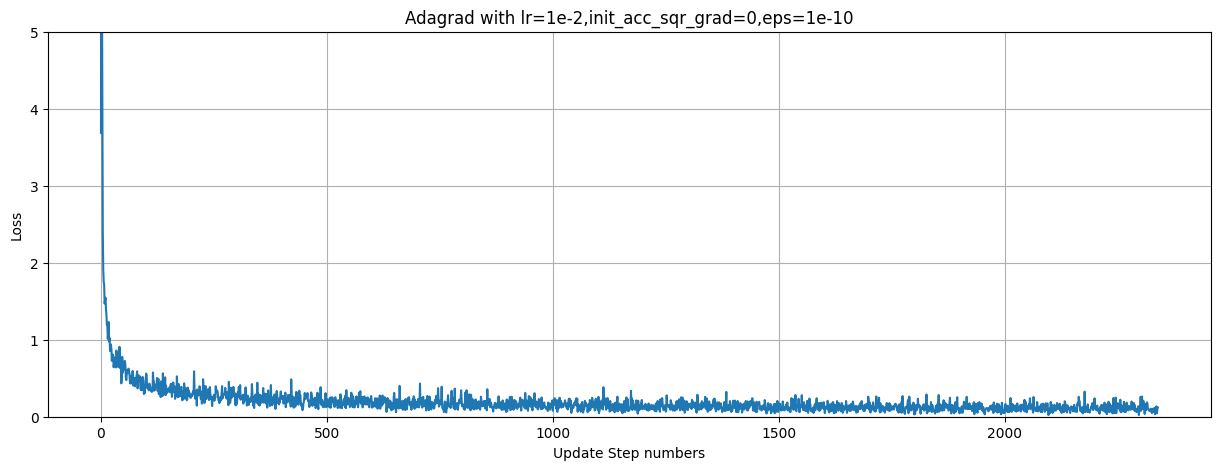

In [29]:
plot_loss(
    loss=adagrad_loss,
    title='Adagrad with lr=1e-2,init_acc_sqr_grad=0,eps=1e-10',ymax=5.0
)

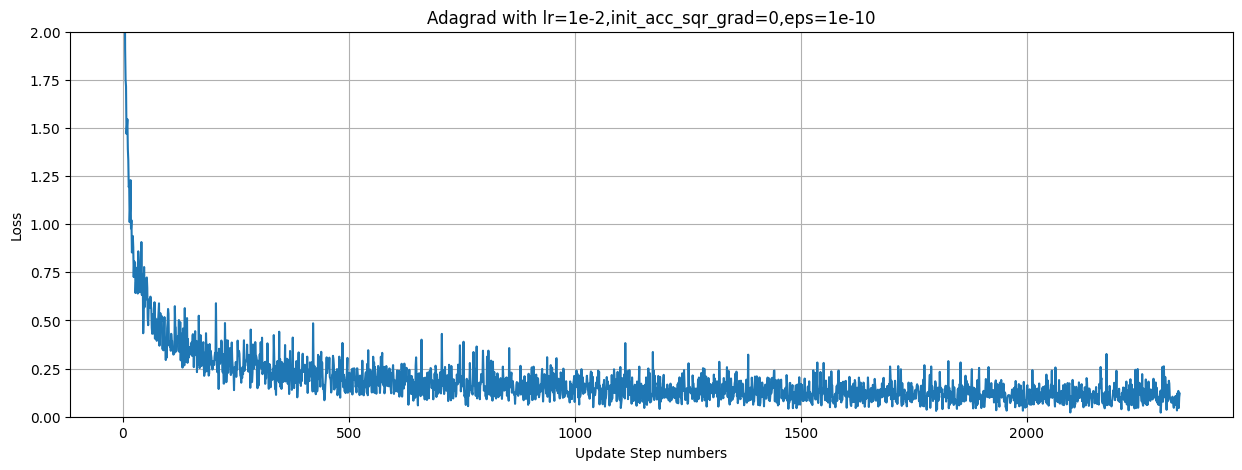

In [30]:
plot_loss(
    loss=adagrad_loss,
    title='Adagrad with lr=1e-2,init_acc_sqr_grad=0,eps=1e-10',ymax=2.0
)

现在我们进一步缩小了 y 轴展示的刻度，我们现在已经可以清楚的看到，Adagrad 优化器其实也会在收敛极值的局部微小附近产生小毛刺儿现象；

继续，我们再将前序已经产生的三个优化器下降的 loss 过程绘制在相同的画布内，对比一下效果；

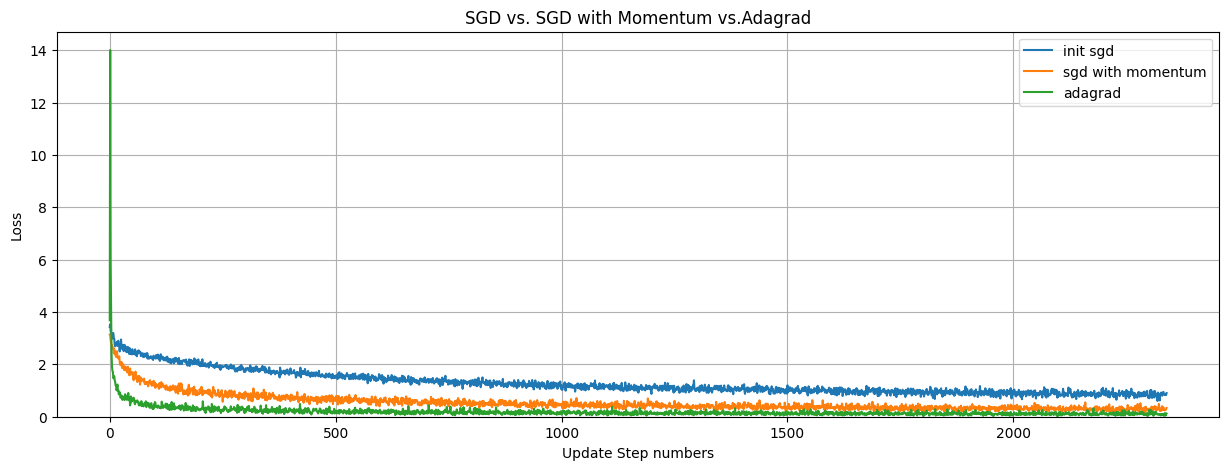

In [31]:
losses = [sgd_loss,sgd_with_momentum_loss,adagrad_loss]
labels = ['init sgd','sgd with momentum','adagrad']
plot_losses(
    losses=losses,
    labels=labels,
    title='SGD vs. SGD with Momentum vs.Adagrad'
)

至此，三个优化器的原始对比就完成了；

但是，刚才我们在实现 Adagrad 的时候，关于累积梯度平方的那个向量，我们给定的向量初始化值为0；现在我们看看，如果更改这个值，Adagrad 的 loss 下降又会产生什么不一样的效果；


In [32]:
# 初始化Adagrad loss 下降在不同 init_acc_sqr_grad 超参值情况下的 loss 下降值的收集变量，我们直接将其构建为一个字典，方便组织并方便代码的处理；
adagrad_losses = {
    
    # 表示init_acc_sqr_grad=0 时 loss 的下降产生的效果
    0:adagrad_loss
}

In [33]:
# 实例化一个新的优化器，新优化器中init_acc_sqr_grad的值置为 1.0
optimizer = Adagrad(
    model_params=model.parameters(),
    init_acc_sqr_grad=1.0
)

In [34]:
# 新优化器优化模型训练
adagrad_losses[1.0] = train(
    train_iterator=train_iterator,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=HP.device
)

100%|██████████| 468/468 [00:17<00:00, 26.77it/s]


In [35]:
# 实例化一个新的优化器，新优化器中init_acc_sqr_grad的值置为 1.0
optimizer = Adagrad(
    model_params=model.parameters(),
    init_acc_sqr_grad=0.1
)

In [36]:
# 新优化器优化模型训练
adagrad_losses[0.1] = train(
    train_iterator=train_iterator,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=HP.device
)

100%|██████████| 468/468 [00:17<00:00, 26.97it/s]


In [37]:
# 实例化一个新的优化器，新优化器中init_acc_sqr_grad的值置为 1.0
optimizer = Adagrad(
    model_params=model.parameters(),
    init_acc_sqr_grad=0.01
)

In [38]:
# 新优化器优化模型训练
adagrad_losses[0.01] = train(
    train_iterator=train_iterator,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=HP.device
)

100%|██████████| 468/468 [00:17<00:00, 26.68it/s]


In [39]:
# 实例化一个新的优化器，新优化器中init_acc_sqr_grad的值置为 1.0
optimizer = Adagrad(
    model_params=model.parameters(),
    init_acc_sqr_grad=0.001
)

In [40]:
# 新优化器优化模型训练
adagrad_losses[0.001] = train(
    train_iterator=train_iterator,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=HP.device
)

100%|██████████| 468/468 [00:17<00:00, 26.99it/s]


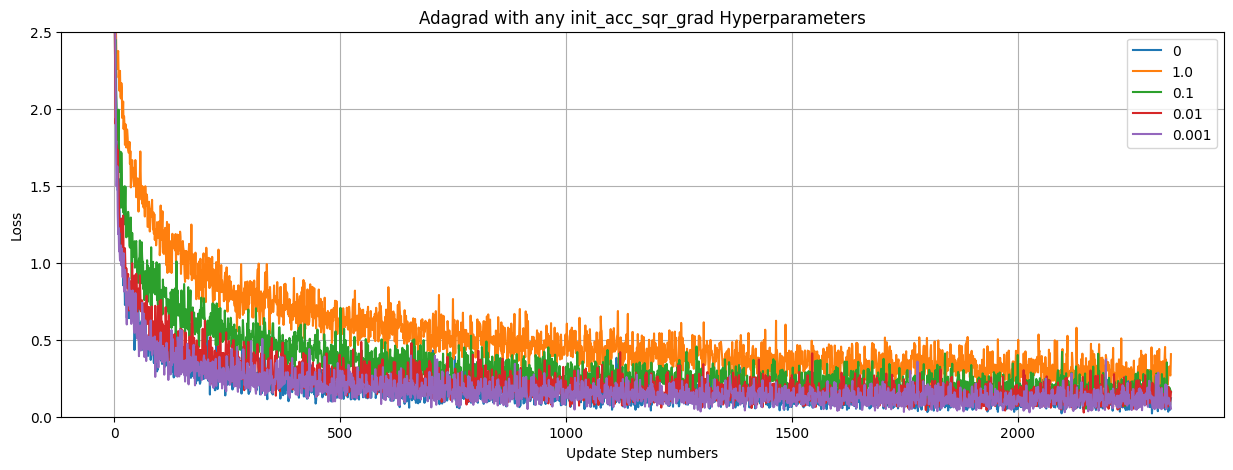

In [41]:
# 同时可视化这四组 loss 的下降，看看不同的init_acc_sqr_grad超参取值，loss 下降的效果有何不同
labels,losses = zip(*adagrad_losses.items())
plot_losses(
    losses=losses,
    labels=labels,
    title='Adagrad with any init_acc_sqr_grad Hyperparameters',
    ymax=2.5
)

经验总结：关于 Adagrad 中，初始化的用于累积梯度平方的权重参数的向量，建议向量中的初始化值给为一个非常接近于 0 的值；

研究完毕 Adagrad 之后，接下来我们研究一下 AdaDelta；

我们先给出AdaDelta 的计算公式：

累积梯度的平方的计算公式：
$$
E\left[g^2\right]_t=\rho E\left[g^2\right]_{t-1}+(1-\rho) g_t^2
$$

计算分子分母的 RMS 的计算公式：
$$
\operatorname{RMS}[g]_t=\sqrt{E\left[g^2\right]_t+\varepsilon}, \quad \operatorname{RMS}[\Delta x]_{t-1}=\sqrt{E\left[\Delta x^2\right]_{t-1}+\varepsilon} .
$$

Delta 的计算公式：
$$
\Delta x_t=-\frac{\operatorname{RMS}[\Delta x]_{t-1}}{\operatorname{RMS}[g]_t} g_t .
$$

权重参数的更新公式：
$$
x_{t+1}=x_t+\Delta x_t
$$


In [42]:
class AdaDelta(object):
    '''
    AdaDelta 优化器代码实现
    '''
    
    def __init__(self,model_params,lr=1.0,rho=0.9,eps=1e-6):
        '''
        :params rho:就是那个衰减率，用于累积梯度平方的，但是它表示的是上一步动量的衰减系数；
        '''
        
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        
        # 为每个参数初始化累积平方梯度的滑动平均张量，初始全0
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        
        # 为每个参数初始化累积更新量（delta）的滑动平均张量，初始全 0
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params]
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None
            
    @torch.no_grad()
    def step(self):
        '''
        计算步骤：
            1.先计算滑动平均的平方梯度的累积
        '''
        
        for param,avg_sqr_grad,avg_sqr_delta in zip(
            self.model_params,
            self.avg_sqr_grads,
            self.avg_sqr_deltas
        ):
            # 1.更新滑动平均的平方梯度的累积
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1-self.rho))
            
            # 2.计算rms
            std = avg_sqr_grad.add(self.eps).sqrt()
            
            # 3.算更新量，同步我算出这个分式的比值
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            
            # 4.按照delta更新参数
            param.sub_(self.lr * delta)
            
            # 5.最关键的一步：更新滑动平均的梯度平方的累积
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1-self.rho))
            

In [43]:
# 创建AdaDelta优化器
optimizer = AdaDelta(model.parameters())

In [44]:
adadelta_loss = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.60it/s]


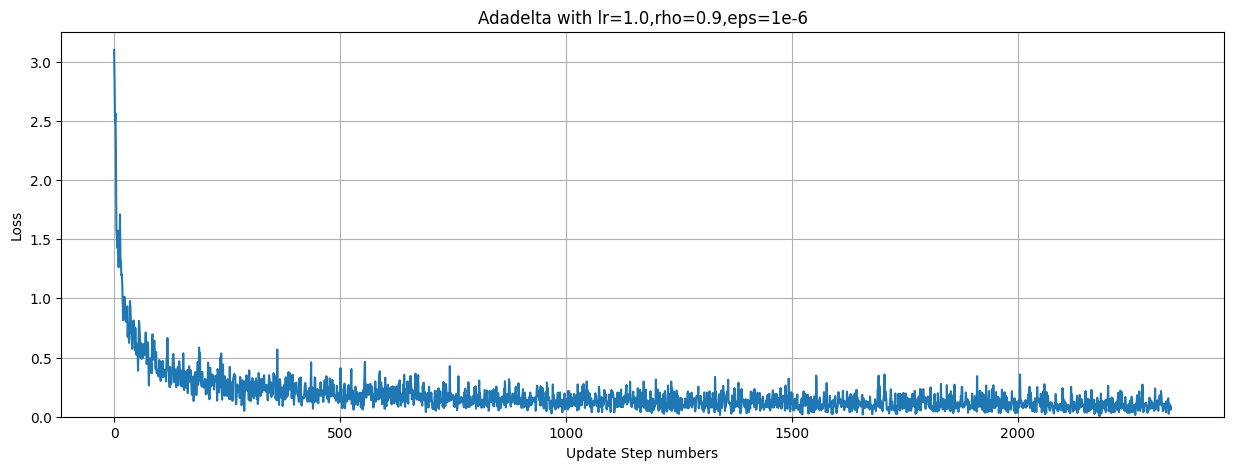

In [45]:
plot_loss(adadelta_loss,'Adadelta with lr=1.0,rho=0.9,eps=1e-6')

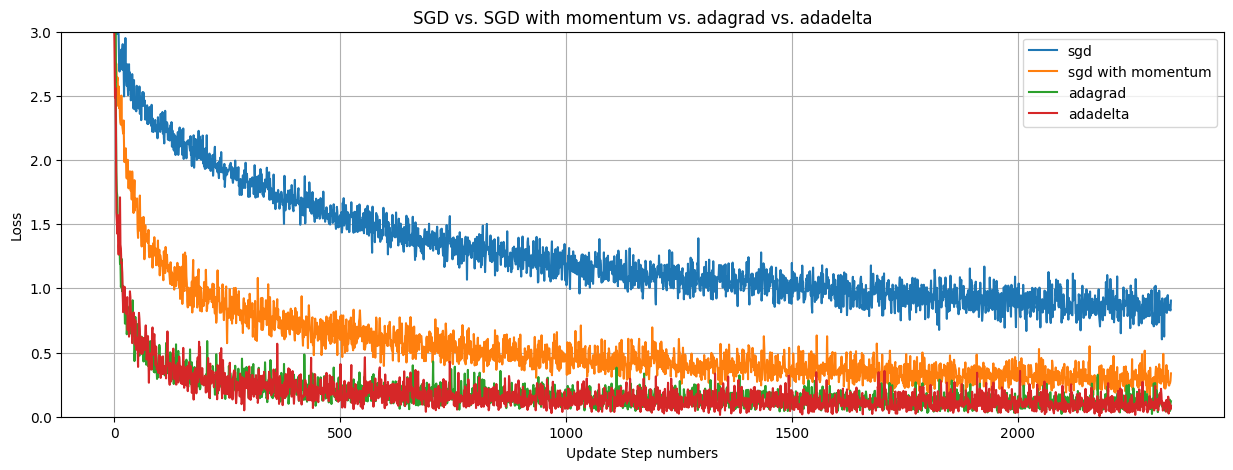

In [46]:
# 将这四种优化器的下降绘制在同一画布，对比一下效果
losses = [sgd_loss,sgd_with_momentum_loss,adagrad_loss,adadelta_loss]
labels = ['sgd','sgd with momentum','adagrad','adadelta']
plot_losses(losses,labels,title='SGD vs. SGD with momentum vs. adagrad vs. adadelta',ymax=3.0)

继续；我们再看下 RMSProp 优化器；

梯度的平方的累积公式：
$$
E[g^2]_t \;=\; \rho\,E[g^2]_{t-1} \;+\;(1-\rho)\,g_t^2  
$$

PyTorch 库中实现的 RMSProp 的参数更新公式：
$$
\theta_{t+1}
   = \theta_t
     - \frac{\eta}{\sqrt{E[g^2]_t}+ \varepsilon}\;g_t  
$$

In [49]:
class RMSpropWithPyTorch(object):
    
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        
        # 将传入的模型参数可迭代对象转换为列表，方便后续遍历和索引
        self.model_params = list(model_params)
        
        # 设置全局学习率，用于控制每次参数更新的步长大小
        self.lr = lr
        
        # 设置衰减因子 alpha（有时也称为 rho），用于平滑历史梯度平方的滑动平均
        self.alpha = alpha
        
        # 极小常数 eps，用于数值稳定，防止除以零或开方出现 NaN
        self.eps = eps
        
        # 为每个参数初始化累积平方梯度的滑动平均张量，初始全零
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        """
        清空所有模型参数的梯度。
        在每次反向传播前调用，确保梯度不会在多次反向传播时累加。
        """
        for param in self.model_params:
            # 将 param.grad 置为 None，即清除旧的梯度
            param.grad = None

    @torch.no_grad()
    def step(self):
        """
        根据 RMSprop 算法更新模型参数：
        1. 更新滑动平均的平方梯度
        2. 计算标准差调整项
        3. 按比例调整梯度并更新参数
        使用 @torch.no_grad() 装饰器，确保这些操作不被纳入计算图。
        """
        # 同时遍历参数及其对应的平均平方梯度
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            
            # 1. 更新滑动平均的平方梯度：
            #    E[g^2] = alpha * E[g^2] + (1 - alpha) * (grad^2)
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))

            # 2. 计算标准差项：sqrt(E[g^2]) + eps
            std = avg_sqr_grad.sqrt().add(self.eps)

            # 3. 更新参数：param = param - (lr / std) * grad
            #    即对每个维度的梯度按其历史 RMS 大小进行缩放
            param.sub_( (self.lr / std) * param.grad )


In [50]:
optimizer = RMSpropWithPyTorch(model.parameters())
rmsprop_loss = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.79it/s]


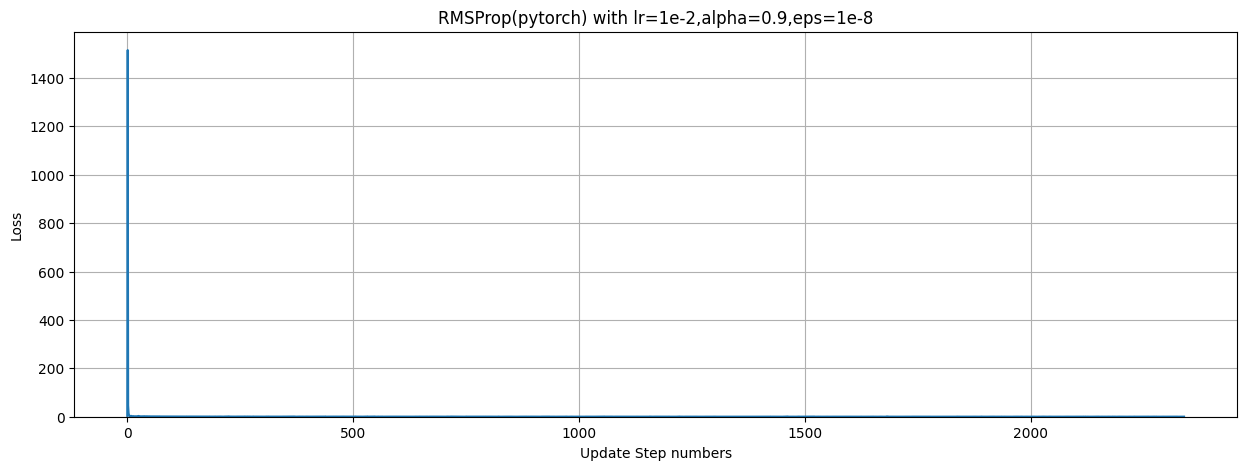

In [63]:
rmsprop_torch_loss = rmsprop_loss
plot_loss(rmsprop_torch_loss,'RMSProp(pytorch) with lr=1e-2,alpha=0.9,eps=1e-8')

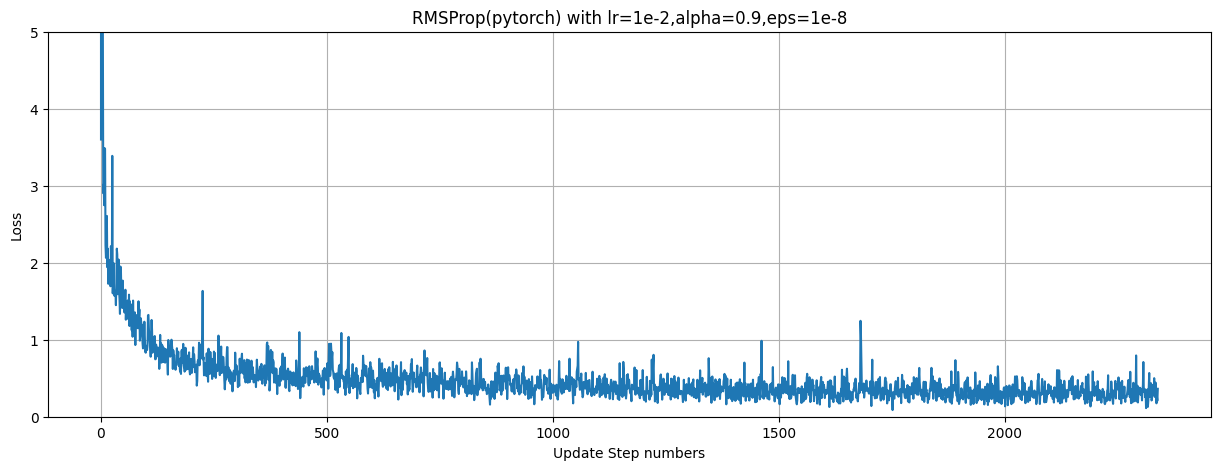

In [64]:
plot_loss(rmsprop_torch_loss,'RMSProp(pytorch) with lr=1e-2,alpha=0.9,eps=1e-8',ymax=5.0)

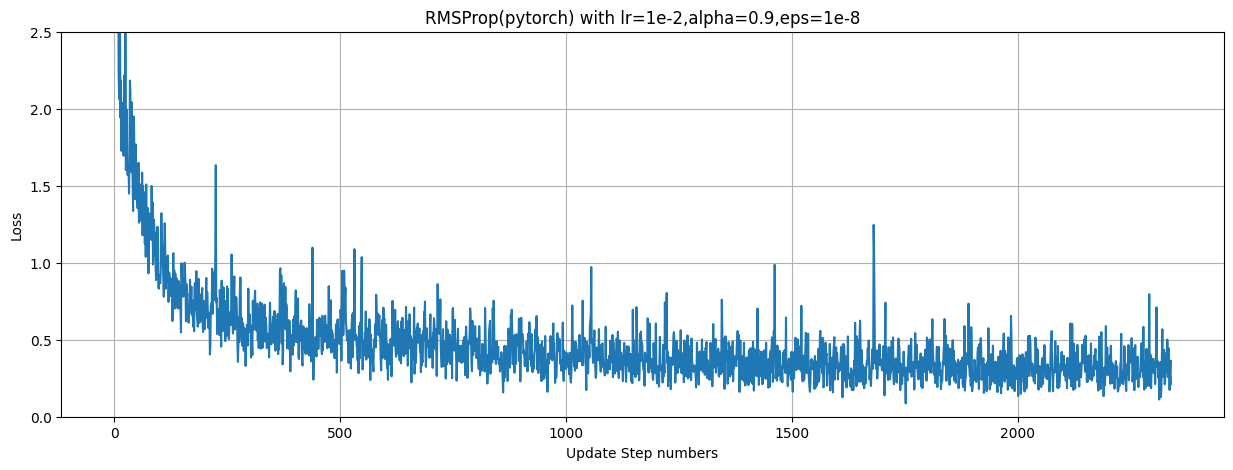

In [65]:
plot_loss(rmsprop_torch_loss,'RMSProp(pytorch) with lr=1e-2,alpha=0.9,eps=1e-8',ymax=2.5)

其实，我们现在完成的 RMSProp 的代码，其实是 PyTorch 中的 RMSProp 的实现：
- 即参数更新中，数值稳定因子$\epsilon$它是独立在$E(g_t^2)$的开根号之外的；

而深度学习框架不止一种，还有另外一个常用的框架：Tensorflow；在 Tensorflow 中，实现 RMSProp 的方式与 PyTorch 中的实现方式略有不同：
- 在 Tensorflow 中，这个 $\epsilon$它是放在$E(g_t^2)$的平方根内的；

即，Tensorflow 版本的 RMSProp 的代码实现是这样的：

In [58]:
class RMSpropWithTensorflow(object):
    
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        
        # 将传入的模型参数可迭代对象转换为列表，方便后续遍历和索引
        self.model_params = list(model_params)
        
        # 设置全局学习率，用于控制每次参数更新的步长大小
        self.lr = lr
        
        # 设置衰减因子 alpha（有时也称为 rho），用于平滑历史梯度平方的滑动平均
        self.alpha = alpha
        
        # 极小常数 eps，用于数值稳定，防止除以零或开方出现 NaN
        self.eps = eps
        
        # 为每个参数初始化累积平方梯度的滑动平均张量，初始全零
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        """
        清空所有模型参数的梯度。
        在每次反向传播前调用，确保梯度不会在多次反向传播时累加。
        """
        for param in self.model_params:
            # 将 param.grad 置为 None，即清除旧的梯度
            param.grad = None

    @torch.no_grad()
    def step(self):
        """
        根据 RMSprop 算法更新模型参数：
        1. 更新滑动平均的平方梯度
        2. 计算标准差调整项
        3. 按比例调整梯度并更新参数
        使用 @torch.no_grad() 装饰器，确保这些操作不被纳入计算图。
        """
        # 同时遍历参数及其对应的平均平方梯度
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            
            # 1. 更新滑动平均的平方梯度：
            #    E[g^2] = alpha * E[g^2] + (1 - alpha) * (grad^2)
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))

            # 2. 计算标准差项：sqrt(E[g^2] + eps)
            std = avg_sqr_grad.add(self.eps).sqrt()

            # 3. 更新参数：param = param - (lr / std) * grad
            #    即对每个维度的梯度按其历史 RMS 大小进行缩放
            param.sub_( (self.lr / std) * param.grad )


In [59]:
optimizer = RMSpropWithTensorflow(model.parameters())
rmsprop_tensorflow_loss = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.40it/s]


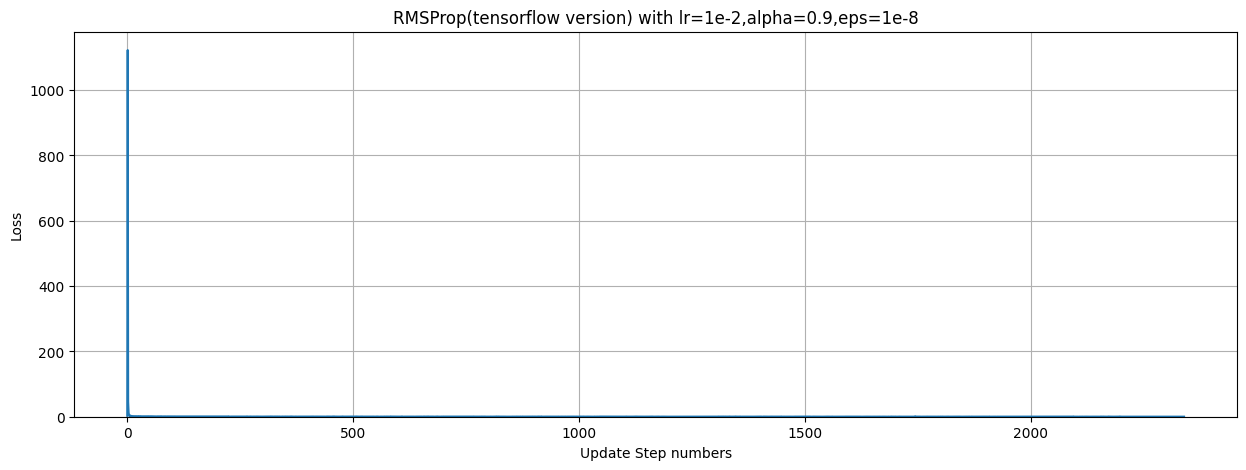

In [60]:
plot_loss(rmsprop_tensorflow_loss,'RMSProp(tensorflow version) with lr=1e-2,alpha=0.9,eps=1e-8')

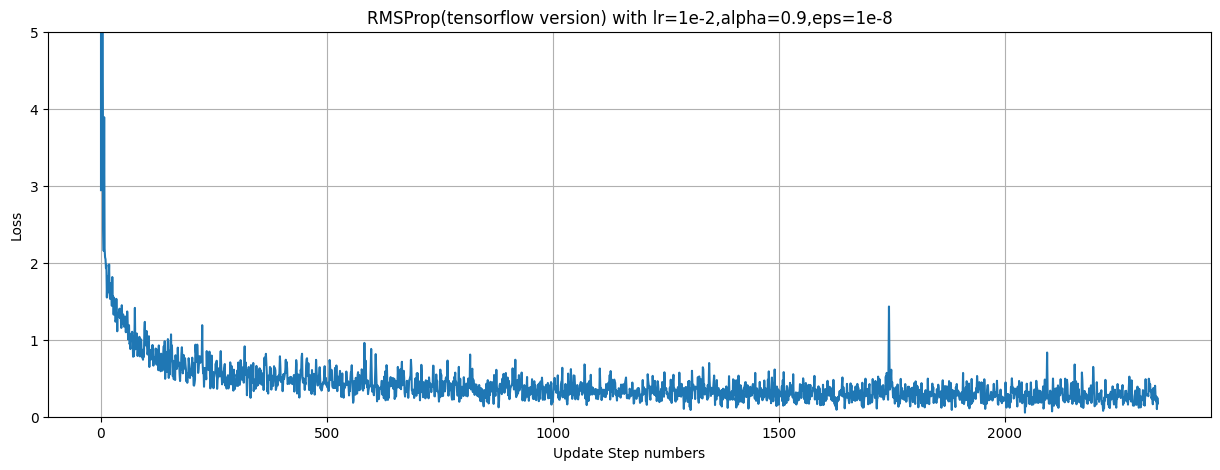

In [61]:
plot_loss(rmsprop_tensorflow_loss,'RMSProp(tensorflow version) with lr=1e-2,alpha=0.9,eps=1e-8',ymax=5.0)

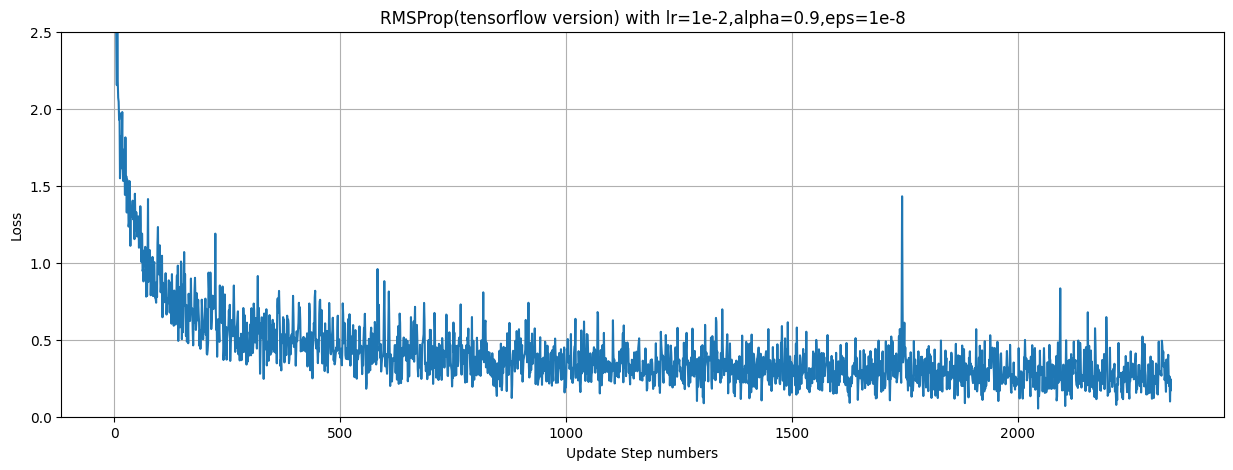

In [62]:
plot_loss(rmsprop_tensorflow_loss,'RMSProp(tensorflow version) with lr=1e-2,alpha=0.9,eps=1e-8',ymax=2.5)

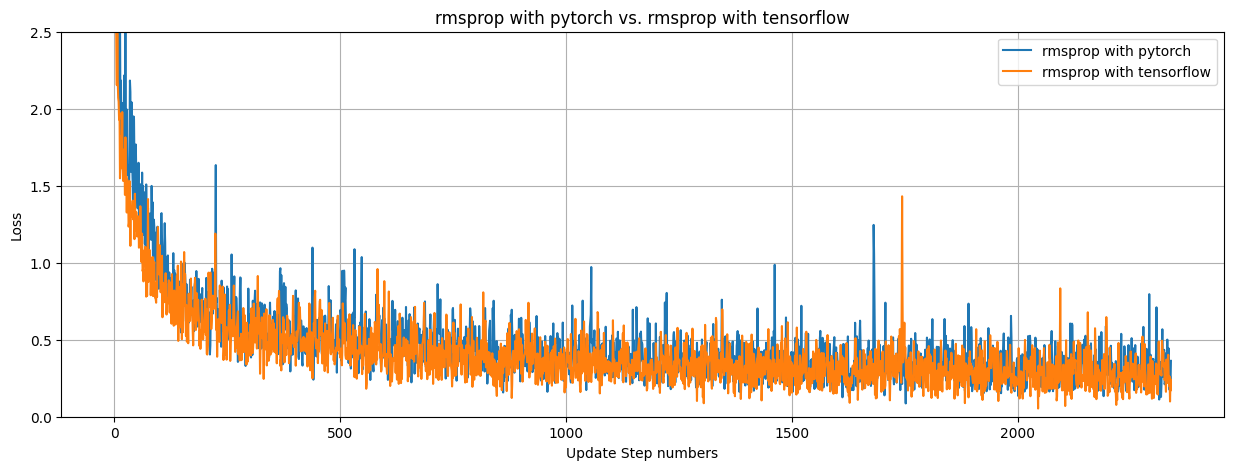

In [67]:
# 现在对比 torch 版本的 rmsprop 和 Tensorflow 版本的 rmsprop 的 loss 下降可视化
losses = [rmsprop_torch_loss,rmsprop_tensorflow_loss]
labels = ['rmsprop with pytorch','rmsprop with tensorflow']
plot_losses(losses,labels,title='rmsprop with pytorch vs. rmsprop with tensorflow',ymax=2.5)

通过上述的图示对比，我们基本可以判断：
- Tensorflow 版本的 RMSProp (即将$\epsilon$加在$\sqrt{}$下的效果，比加在$\sqrt{}$外的效果更好)，loss 的收敛会更加稳定；

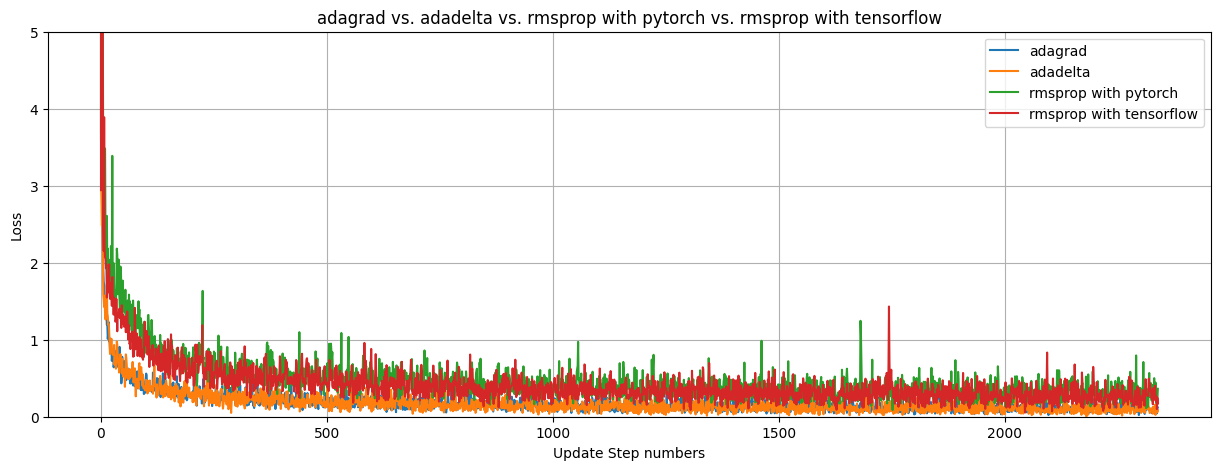

In [69]:
losses = [adagrad_loss,adadelta_loss,rmsprop_torch_loss,rmsprop_tensorflow_loss]
labels = ['adagrad','adadelta','rmsprop with pytorch','rmsprop with tensorflow']
plot_losses(losses,labels,title='adagrad vs. adadelta vs. rmsprop with pytorch vs. rmsprop with tensorflow',ymax=5.0)

考虑到 epsilon 后续常用于强化学习模型的训练过程，所以其中这个$\epsilon$超参数的取值不同，也会导致模型产生不同的 loss 下降过程；

In [88]:
rmsprop_losses = {1e-8:rmsprop_torch_loss} # 让其作为baseline基线标准

In [89]:
rmsprop_torch_eps_losses = rmsprop_losses

In [71]:
optimizer = RMSpropWithPyTorch(model.parameters(),eps=1e-6)
rmsprop_losses[1e-6] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.40it/s]


In [72]:
optimizer = RMSpropWithPyTorch(model.parameters(),eps=1e-4)
rmsprop_losses[1e-4] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.28it/s]


In [73]:
optimizer = RMSpropWithPyTorch(model.parameters(),eps=1e-2)
rmsprop_losses[1e-2] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.04it/s]


In [74]:
optimizer = RMSpropWithPyTorch(model.parameters(),eps=1)
rmsprop_losses[1] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.40it/s]


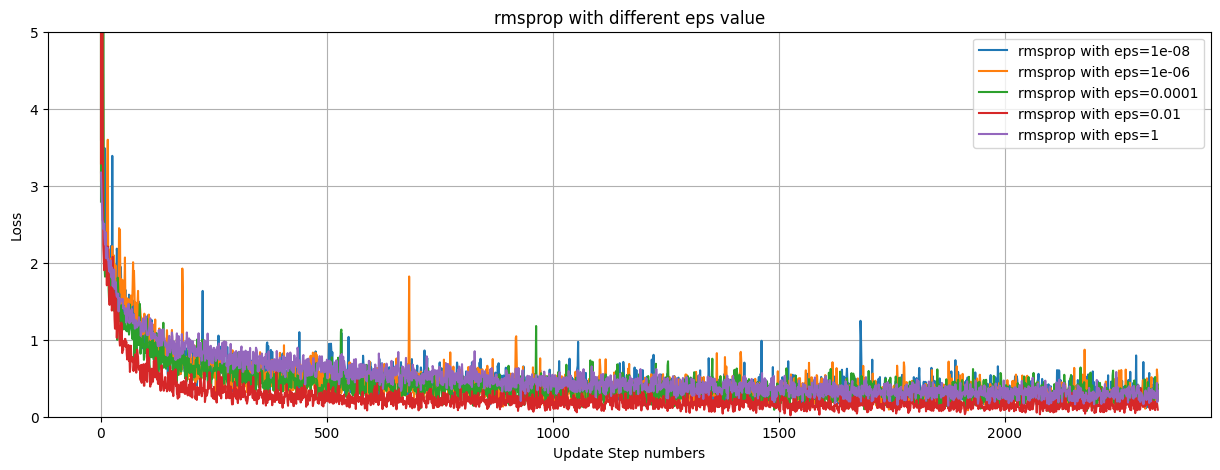

In [76]:
labels,losses = zip(*rmsprop_losses.items())
labels = [f'rmsprop with eps={i}' for i in list(labels)]

plot_losses(losses,labels,title='rmsprop with different eps value',ymax=5.0)

通过上述对比可视化图示，我们可以总结：
- 其实，适度的增大这个$\epsilon$有利于一定程度上提升 RMSProp 的收敛稳定性，即毛细现象有很好的缓解；
- 但其实，最佳的$\epsilon$并不是 1，而且你已经发现，紫色线其实不是一个收敛效果较好的曲线，反而是红色线，即$\epsilon=0.01$时，反而 RMSProp 取得了最优性能；
- 而且，当$\epsilon=1$时，其实 RMSProp 的性能是最差的；

继续：我们再来比较一下 Tensorflow 版本的 RMSProp 在$\epsilon$取不同值时的 loss 下降效果；

In [90]:
rmsprop_losses = {1e-8:rmsprop_tensorflow_loss} # 让其作为baseline基线标准

In [80]:
optimizer = RMSpropWithTensorflow(model.parameters(),eps=1e-6)
rmsprop_losses[1e-6] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.53it/s]


In [81]:
optimizer = RMSpropWithTensorflow(model.parameters(),eps=1e-4)
rmsprop_losses[1e-4] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.56it/s]


In [82]:
optimizer = RMSpropWithTensorflow(model.parameters(),eps=1e-2)
rmsprop_losses[1e-2] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.39it/s]


In [83]:
optimizer = RMSpropWithTensorflow(model.parameters(),eps=1)
rmsprop_losses[1] = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:17<00:00, 26.53it/s]


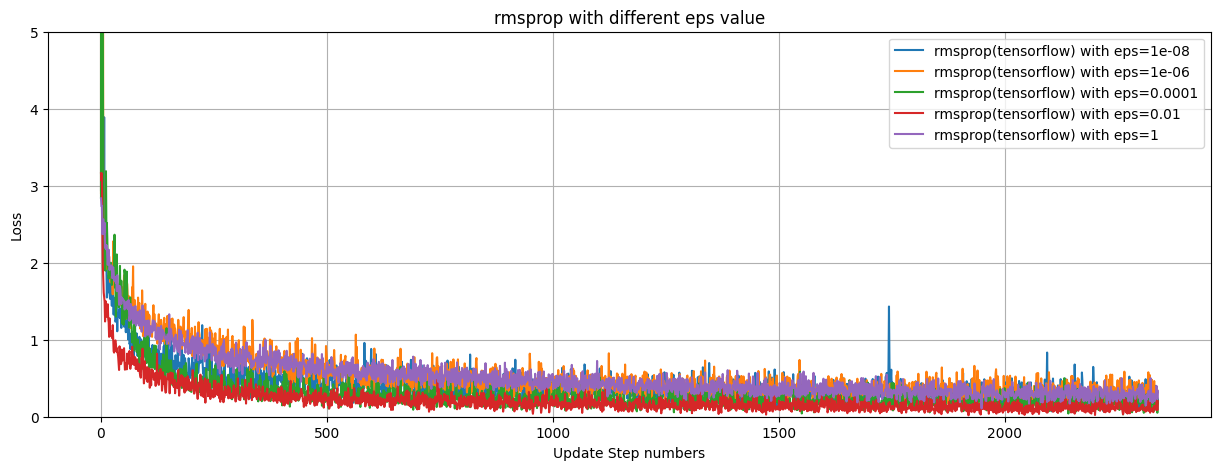

In [84]:
labels,losses = zip(*rmsprop_losses.items())
labels = [f'rmsprop(tensorflow) with eps={i}' for i in list(labels)]

plot_losses(losses,labels,title='rmsprop with different eps value',ymax=5.0)

现在再看 Tensorflow 版本的 RMSProp，发现仍然也是在$\epsilon=0.01$时产生了最优性能；

In [91]:
rmsprop_tensorflow_eps_losses = rmsprop_losses

In [92]:
# 现在对比torch和Tensorflow版本的RMSProp在eps=0.01 时的最佳性能
losses = [rmsprop_torch_eps_losses[1e-2],rmsprop_tensorflow_eps_losses[1e-2]]
labels = ['rmsprop with torch eps=1e-2','rmsprop with tensorflow eps=1e-2']
plot_losses(losses,labels,title='rmsprop with torch vs. tensorflow,eps=1e-2',ymax=5.0)

# 这里其实不是报错，只是我暂时不想再把上述的两个四轮训练再跑一遍，很烦，你们拿到代码的时候直接按照代码块的顺序依次向下执行，到这时，这里的绘图就正确了；

KeyError: 0.01

至此，RMSProp的分析就结束了；接下来我们看最后一个优化器的实现：Adam；

当前梯度的计算公式：
$$
g_t=\nabla_\theta f_t\left(\theta_{t-1}\right)
$$

更新一阶和二阶矩的计算公式：
$$
\begin{aligned}
m_t & =\beta_1 m_{t-1}+\left(1-\beta_1\right) g_t, \\
v_t & =\beta_2 v_{t-1}+\left(1-\beta_2\right) g_t^2 \quad \text { (逐元素平方) }
\end{aligned}
$$

偏置矫正的计算公式：
$$
\hat{m}_t=\frac{m_t}{1-\beta_1^t}, \quad \hat{v}_t=\frac{v_t}{1-\beta_2^t}
$$

参数更新公式：
$$
\theta_t=\theta_{t-1}-\alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t}+\epsilon}
$$

In [93]:
class Adam(object):
    
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        
        # 将传入的模型参数可迭代对象转换为列表，便于后续遍历和索引
        self.model_params = list(model_params)
        
        # 设置全局学习率，用于控制参数更新步长
        self.lr = lr
        
        # 拆包一阶和二阶矩的衰减系数 beta1, beta2
        self.beta_1, self.beta_2 = betas
        
        # 极小常数 eps，防止除以零和数值不稳定
        self.eps = eps
        
        # 初始化一阶矩（梯度均值）的滑动平均张量列表，初始全零
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        
        # 初始化二阶矩（梯度平方均值）的滑动平均张量列表，初始全零
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        
        # 记录更新步数，用于后续的偏差校正
        self.n_steps = 0
        
    def zero_grad(self):
        """
        清空所有模型参数的梯度。
        在每次反向传播前调用，防止梯度在多次反向传播时累加。
        """
        for param in self.model_params:
            
            # 将每个参数的 .grad 属性置为 None，即清除旧梯度
            param.grad = None

    @torch.no_grad()
    def step(self):
        """
        根据 Adam 算法更新模型参数：
        1. 更新一阶矩和二阶矩的滑动平均
        2. 对一阶/二阶矩进行偏差校正
        3. 计算参数更新量并在原地更新参数
        使用 @torch.no_grad() 装饰，确保更新操作不被记录到计算图。
        """
        # 遍历参数及其对应的一阶、二阶矩估计
        for param, avg_grad, avg_sqr_grad in zip(
            self.model_params,
            self.avg_grads,
            self.avg_sqr_grads
        ):
            
            # 1. 增加步数计数，用于偏差校正
            self.n_steps += 1

            # 2. 更新一阶矩滑动平均：m_t = beta1 * m_{t-1} + (1 - beta1) * g_t
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))

            # 3. 更新二阶矩滑动平均：v_t = beta2 * v_{t-1} + (1 - beta2) * (g_t^2)
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))

            # 4. 对一阶矩进行偏差校正：m̂_t = m_t / (1 - beta1^t)
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            
            # 5. 对二阶矩进行偏差校正：v̂_t = v_t / (1 - beta2^t)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)

            # 6. 计算校正后二阶矩的标准差项：sqrt(v̂_t) + eps
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)

            # 7. 按照 Adam 更新公式更新参数：
            #    θ = θ - lr * m̂_t / (sqrt(v̂_t) + eps)
            param.sub_(self.lr * avg_grad_corrected.div(std))


In [94]:
optimizer = Adam(model.parameters())
adam_loss = train(train_iterator,model,optimizer,criterion,HP.device)

100%|██████████| 468/468 [00:18<00:00, 25.84it/s]


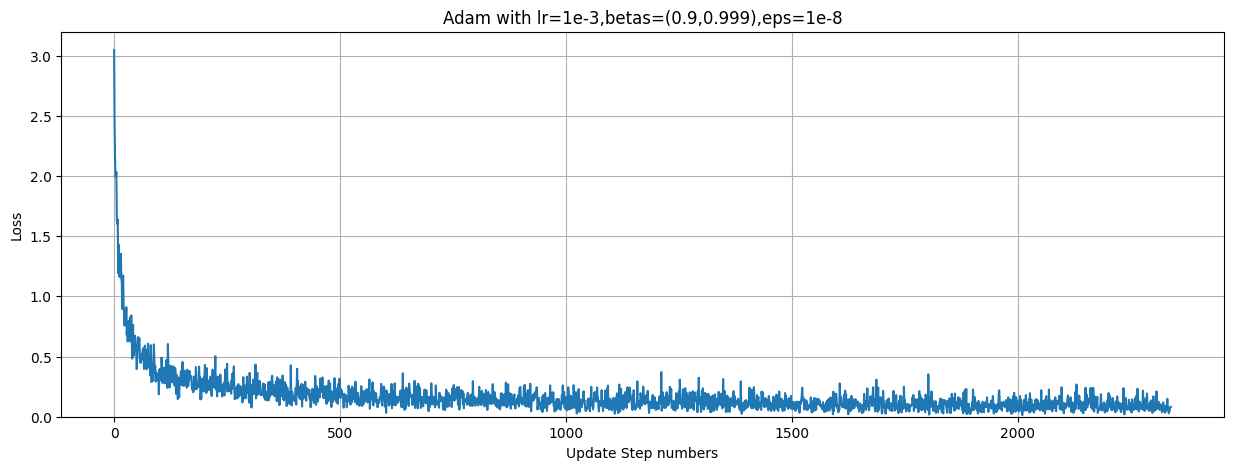

In [95]:
plot_loss(adam_loss,'Adam with lr=1e-3,betas=(0.9,0.999),eps=1e-8')

至此，我们绘制完毕了五大类优化器；我们将其放在同一个画布中进行最后的对比；

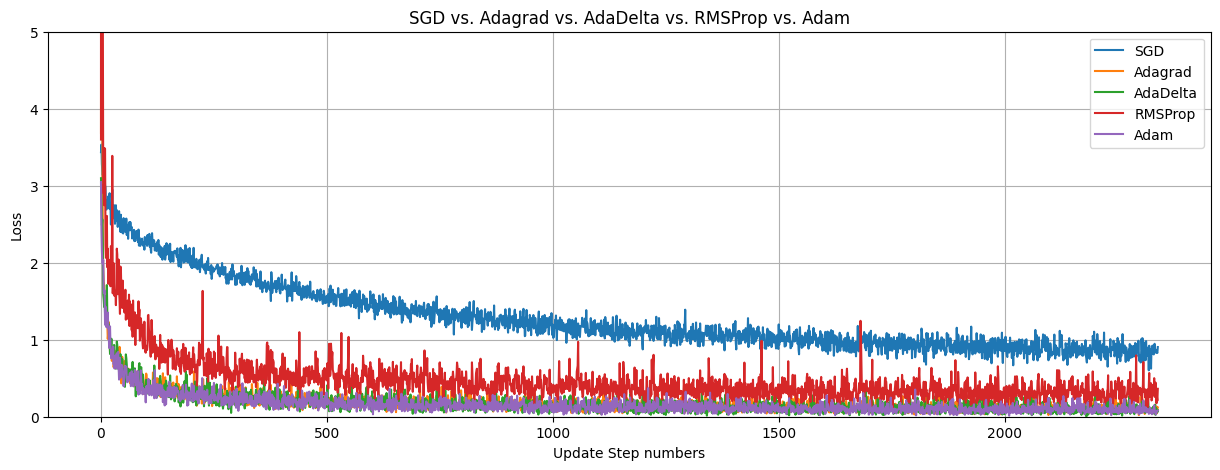

In [97]:
losses = [sgd_loss,adagrad_loss,adadelta_loss,rmsprop_loss,adam_loss]
labels = ['SGD','Adagrad','AdaDelta','RMSProp','Adam']
plot_losses(losses,labels,title='SGD vs. Adagrad vs. AdaDelta vs. RMSProp vs. Adam',ymax=5.0)

# 总结
上述，我们绘制了：
- 随机梯度下降优化器；
- 自适应梯度下降优化器；
- AdaDelta 优化器；
- RMSProp 均方根支撑优化器；
- 自适应矩估计优化器；

并且辅助以不同的绘图，对比了上述各个优化器之间的性能优劣；

当然了，代码至此，可以很好的继续举一反三，例如：
- 你可以尝试继续对各个优化器中的超参数改变它的值，并观察 loss 的下降是否出现新的变化规律；
- 你也可以继续根据上述代码的整体框架，把一些咱们没写到的优化器，比如 NAG(内斯特罗夫加速梯度动量、AdamW 等)优化器对照标准计算公式尝试自行使用代码实现；